# NSAI Level 0: TF-IDF Intent Classification with Logistic Regression
This notebook demonstrates intent classification using TF-IDF vectorization combined with Logistic Regression.
It includes preprocessing, training, and comprehensive evaluation metrics.

In [14]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import pickle
import os
import re
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
print('Libraries imported successfully!')

Libraries imported successfully!


## Section 1: Load Dataset

In [15]:
# Load the dataset
data_path = '../data/intents_base.csv'
df = pd.read_csv(data_path)

print(f'Dataset loaded successfully!')
print(f'Total records: {len(df)}')
print(f'Dataset shape: {df.shape}')
print('\nFirst few records:')
print(df.head())
print('\nIntent distribution:')
print(df['intent'].value_counts())

Dataset loaded successfully!
Total records: 614
Dataset shape: (614, 2)

First few records:
                                 utterance       intent
0           why is server host123 cpu high  investigate
1        check memory usage on db-server-7  investigate
2        what caused the outage last night  investigate
3  show me errors from the last deployment  investigate
4      analyze why response time increased  investigate

Intent distribution:
intent
out_of_scope     169
execution        150
investigate      149
summarization    146
Name: count, dtype: int64


## Section 2: Text Preprocessing

In [16]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'^"|"$', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['utterance_processed'] = df['utterance'].apply(preprocess_text)

print('Text preprocessing completed!')
print('\nSample of processed text:')
print(df[['utterance', 'utterance_processed']].head(10))

Text preprocessing completed!

Sample of processed text:
                                  utterance  \
0            why is server host123 cpu high   
1         check memory usage on db-server-7   
2         what caused the outage last night   
3   show me errors from the last deployment   
4       analyze why response time increased   
5     investigate cpu spike on web-server-3   
6     what is causing high memory on app-01   
7              why did the database go down   
8  show me the root cause of latency issues   
9       analyze the performance degradation   

                        utterance_processed  
0            why is server host123 cpu high  
1         check memory usage on db server 7  
2         what caused the outage last night  
3   show me errors from the last deployment  
4       analyze why response time increased  
5     investigate cpu spike on web server 3  
6     what is causing high memory on app 01  
7              why did the database go down  
8  show me 

## Section 3: TF-IDF Vectorization

In [17]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=100,
    min_df=2,
    max_df=0.9,
    ngram_range=(1, 2),
    stop_words='english'
)

X_tfidf = vectorizer.fit_transform(df['utterance_processed'])

print(f'TF-IDF vectorization completed!')
print(f'Feature matrix shape: {X_tfidf.shape}')
print(f'Number of features: {len(vectorizer.get_feature_names_out())}')
print('\nTop 20 features:')
print(vectorizer.get_feature_names_out()[:20])

TF-IDF vectorization completed!
Feature matrix shape: (614, 100)
Number of features: 100

Top 20 features:
['analyze' 'api' 'app' 'application' 'apply' 'audit' 'backup' 'brief'
 'cache' 'caused' 'causing' 'certificate' 'changes' 'check' 'cluster'
 'compliance' 'configure' 'connection' 'connection pool' 'container']


## Section 4: Encode Labels and Split Data (80/20)

In [18]:
# Encode intent labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['intent'])

print('Intent labels encoded!')
print('Intent mapping:')
for i, label in enumerate(label_encoder.classes_):
    print(f'  {label}: {i}')

# Split data 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f'\nTrain-Test Split (80-20):')
print(f'Training set size: {X_train.shape[0]}')
print(f'Testing set size: {X_test.shape[0]}')

Intent labels encoded!
Intent mapping:
  execution: 0
  investigate: 1
  out_of_scope: 2
  summarization: 3

Train-Test Split (80-20):
Training set size: 491
Testing set size: 123


## Section 5: Train Logistic Regression Classifier

In [19]:
# Train Logistic Regression Classifier
classifier = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

print('Training Logistic Regression classifier...')
classifier.fit(X_train, y_train)
print('Training completed!')

Training Logistic Regression classifier...
Training completed!


## Section 6: Make Predictions

In [ ]:
# Make predictions with confidence threshold and structured output
# confidence_threshold: operational noise filter, not a decision policy
confidence_threshold = 0.7  # This is a configuration constant, not semantic logic
model_name = "tfidf-linear-v1"
model_version = "2026.02"

results = []
for i in range(len(y_test)):
    utterance = df.iloc[X_test.indices[i]]['utterance'] if hasattr(X_test, 'indices') else None
    true_intent = label_encoder.inverse_transform([y_test[i]])[0]
    proba = y_test_proba[i]
    max_conf = np.max(proba)
    pred_idx = np.argmax(proba)
    pred_intent = label_encoder.inverse_transform([pred_idx])[0]
    abstained = max_conf < confidence_threshold
    output_intent = pred_intent if not abstained else "unknown"
    results.append({
        "utterance": utterance,
        "true_intent": true_intent,
        "intent": output_intent,
        "confidence": float(max_conf),
        "model": model_name,
        "version": model_version,
        "abstained": abstained
    })

results_df = pd.DataFrame(results)
results_df.to_csv("./artifacts/predictions_structured.csv", index=False)

print('Structured predictions with abstain/unknown saved to ./artifacts/predictions_structured.csv')
print(results_df.head())

Structured predictions with abstain/unknown saved to ./artifacts/predictions_structured.csv
                                          utterance    true_intent  \
0     investigate the sudden increase in 5xx errors   out_of_scope   
1                     analyze the failed deployment   out_of_scope   
2  what is causing the oauth token refresh failures   out_of_scope   
3  what is causing the oauth token refresh failures  summarization   
4           show me errors from the last deployment  summarization   

          intent  confidence            model  version  abstained  
0   out_of_scope    0.731842  tfidf-linear-v1  2026.02      False  
1        unknown    0.478170  tfidf-linear-v1  2026.02       True  
2        unknown    0.478170  tfidf-linear-v1  2026.02       True  
3        unknown    0.579438  tfidf-linear-v1  2026.02       True  
4  summarization    0.861024  tfidf-linear-v1  2026.02      False  


## Section 7: Evaluate Model Performance

In [21]:
# Comprehensive Model Evaluation
print('=' * 80)
print('COMPREHENSIVE MODEL EVALUATION')
print('=' * 80)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)

print('\nTRAINING SET METRICS:')
print(f'  Accuracy:  {train_accuracy:.4f} ({train_accuracy*100:.2f}%)')
print(f'  Precision: {train_precision:.4f}')
print(f'  Recall:    {train_recall:.4f}')
print(f'  F1-Score:  {train_f1:.4f}')

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

print('\nTESTING SET METRICS:')
print(f'  Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')
print(f'  Precision: {test_precision:.4f}')
print(f'  Recall:    {test_recall:.4f}')
print(f'  F1-Score:  {test_f1:.4f}')

print('\nPER-CLASS METRICS (Test Set):')
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_, digits=4))

cm = confusion_matrix(y_test, y_test_pred)
print('CONFUSION MATRIX:')
print(cm)

COMPREHENSIVE MODEL EVALUATION

TRAINING SET METRICS:
  Accuracy:  0.9369 (93.69%)
  Precision: 0.9429
  Recall:    0.9369
  F1-Score:  0.9368

TESTING SET METRICS:
  Accuracy:  0.9024 (90.24%)
  Precision: 0.9067
  Recall:    0.9024
  F1-Score:  0.9003

PER-CLASS METRICS (Test Set):
               precision    recall  f1-score   support

    execution     0.8710    0.9000    0.8852        30
  investigate     0.9167    0.7333    0.8148        30
 out_of_scope     0.8500    1.0000    0.9189        34
summarization     1.0000    0.9655    0.9825        29

     accuracy                         0.9024       123
    macro avg     0.9094    0.8997    0.9004       123
 weighted avg     0.9067    0.9024    0.9003       123

CONFUSION MATRIX:
[[27  1  2  0]
 [ 4 22  4  0]
 [ 0  0 34  0]
 [ 0  1  0 28]]


## Section 8: Visualize Results

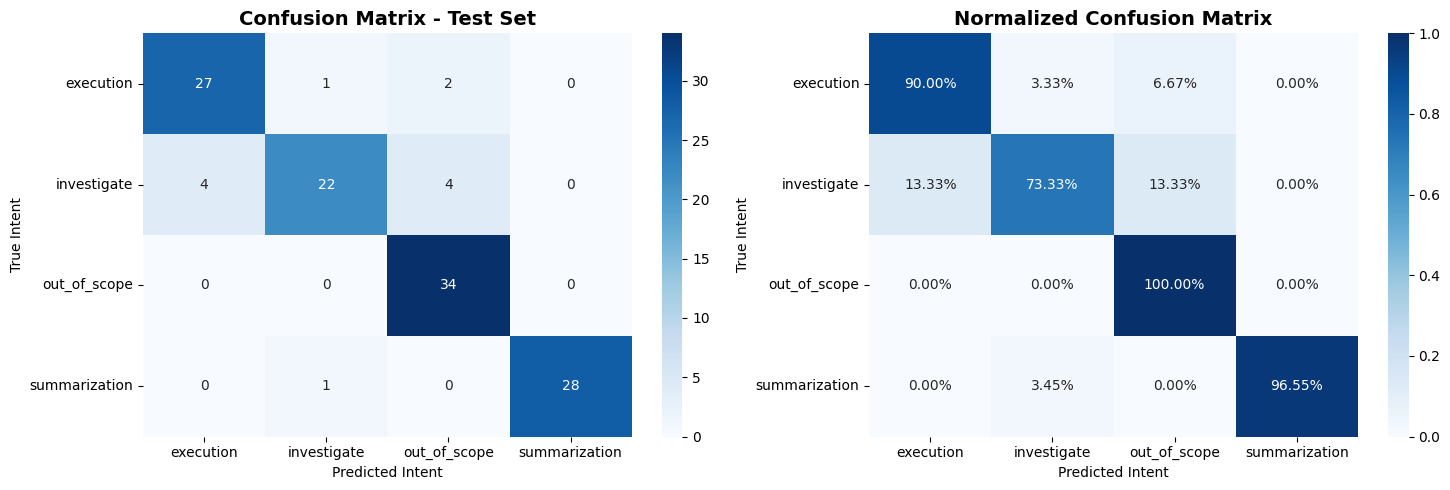

Confusion matrix saved!


In [22]:
# Confusion Matrix Heatmap
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Intent')
axes[0].set_ylabel('True Intent')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Intent')
axes[1].set_ylabel('True Intent')

plt.tight_layout()
os.makedirs('./artifacts', exist_ok=True)
plt.savefig('./artifacts/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print('Confusion matrix saved!')

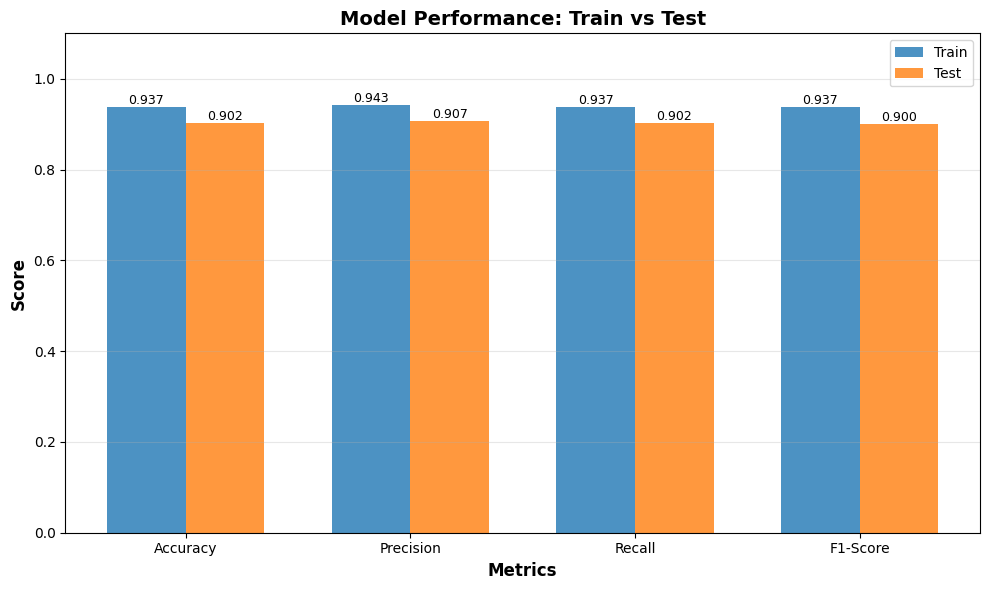

Metrics comparison saved!


In [23]:
# Metrics Comparison Bar Chart
metrics_data = {
    'Accuracy': [train_accuracy, test_accuracy],
    'Precision': [train_precision, test_precision],
    'Recall': [train_recall, test_recall],
    'F1-Score': [train_f1, test_f1]
}

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics_data))
width = 0.35

bars1 = ax.bar(x - width/2, [v[0] for v in metrics_data.values()], width, label='Train', alpha=0.8)
bars2 = ax.bar(x + width/2, [v[1] for v in metrics_data.values()], width, label='Test', alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance: Train vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_data.keys())
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('./artifacts/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print('Metrics comparison saved!')

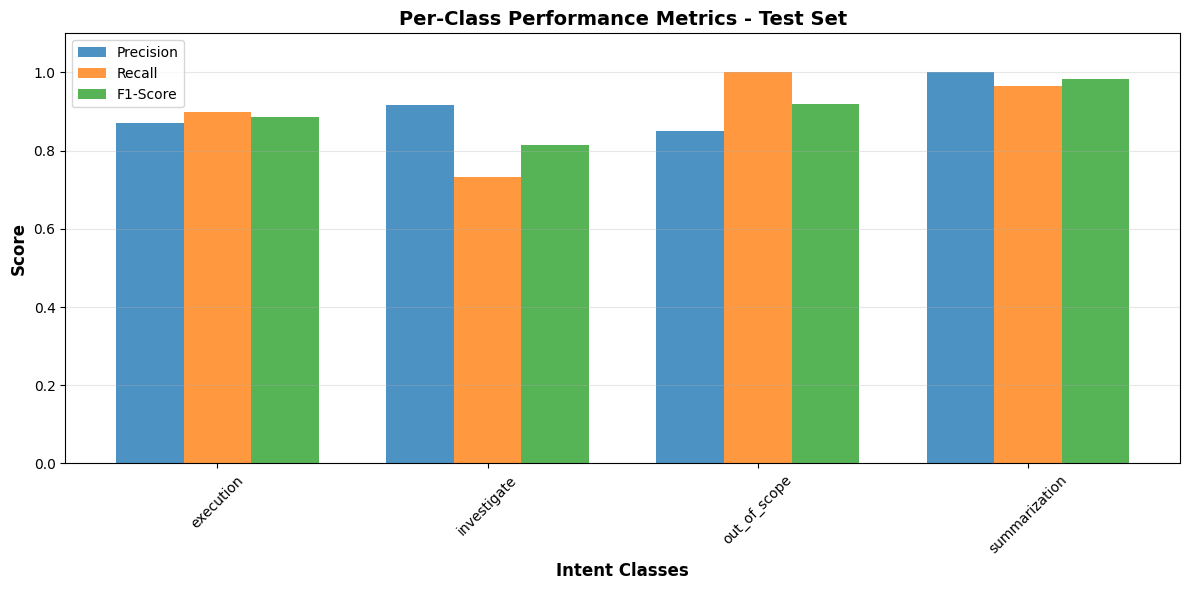

Per-class metrics saved!


In [24]:
# Per-Class Metrics
class_metrics = {
    'Precision': precision_score(y_test, y_test_pred, average=None, zero_division=0),
    'Recall': recall_score(y_test, y_test_pred, average=None, zero_division=0),
    'F1-Score': f1_score(y_test, y_test_pred, average=None, zero_division=0)
}

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(label_encoder.classes_))
width = 0.25

for i, (metric_name, metric_values) in enumerate(class_metrics.items()):
    ax.bar(x + (i-1)*width, metric_values, width, label=metric_name, alpha=0.8)

ax.set_xlabel('Intent Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics - Test Set', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_encoder.classes_, rotation=45)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./artifacts/per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print('Per-class metrics saved!')

## Section 9: Save Model and Artifacts

In [25]:
# Save Model and Artifacts
os.makedirs('./models', exist_ok=True)
os.makedirs('./artifacts', exist_ok=True)

with open('./models/logistic_regression_classifier.pkl', 'wb') as f:
    pickle.dump(classifier, f)
print('Classifier saved to ./models/logistic_regression_classifier.pkl')

with open('./models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print('Vectorizer saved to ./models/tfidf_vectorizer.pkl')

with open('./models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print('Label encoder saved to ./models/label_encoder.pkl')

evaluation_report = {
    'timestamp': datetime.now().isoformat(),
    'dataset': {
        'total_samples': len(df),
        'source': '../data/intents_base.csv'
    },
    'split': {
        'train_size': int(X_train.shape[0]),
        'test_size': int(X_test.shape[0]),
        'train_ratio': 0.8,
        'test_ratio': 0.2
    },
    'training_metrics': {
        'accuracy': float(train_accuracy),
        'precision': float(train_precision),
        'recall': float(train_recall),
        'f1_score': float(train_f1)
    },
    'testing_metrics': {
        'accuracy': float(test_accuracy),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1_score': float(test_f1)
    },
    'intents': list(label_encoder.classes_),
    'num_features': len(vectorizer.get_feature_names_out())
}

with open('./artifacts/evaluation_report.json', 'w') as f:
    json.dump(evaluation_report, f, indent=4)
print('Evaluation report saved to ./artifacts/evaluation_report.json')

print('\n' + '=' * 80)
print('MODEL TRAINING AND EVALUATION COMPLETE!')
print('=' * 80)
print(f'\nTest Accuracy: {test_accuracy*100:.2f}%')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

Classifier saved to ./models/logistic_regression_classifier.pkl
Vectorizer saved to ./models/tfidf_vectorizer.pkl
Label encoder saved to ./models/label_encoder.pkl
Evaluation report saved to ./artifacts/evaluation_report.json

MODEL TRAINING AND EVALUATION COMPLETE!

Test Accuracy: 90.24%
Test Precision: 0.9067
Test Recall: 0.9024
Test F1-Score: 0.9003
